# **Bioinformatics Project - Computational Drug Discovery [Part 4] Model Building**

Alberto Moa

---

In this notebook, I will build several machine learningn models train the dataset of bioactivity data to predict the PIC50 values and evaluate each models.

## 1. Import Data and Required Packages

Import Pandas, Numpy, Matplotlib, Seaborn and SKLearn libraries

In [50]:
# basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

print('Imported Success')


Imported Success


Import the csv Data as DataFrame

In [4]:
# download bioactivity data and store it to df variable
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

# show sample data
df.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.096910


## 2. Preparing Dataset

Preparing X and Y variables

In [9]:
# make X variable from dataset
X = df.drop(['pIC50'], axis=1)

# make y variable from dataset
y = df['pIC50']

In [10]:
# show sample data of x
X.head(5)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Remove low variance features

In [29]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1-.8)))
X = selection.fit_transform(X)

X.shape

(4695, 137)

In [7]:
# show sample data of y
y.head(5)

0    6.124939
1    7.000000
2    4.301030
3    6.522879
4    6.096910
Name: pIC50, dtype: float64

## 3. Model Training

Preparing dataset into train and test set. Propotion of dataset is:
* 80% for train set
* 20 for test set

In [85]:
# separate dataset into temp and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345)

In [86]:
# show shape of splitting dataset
X_train.shape, X_test.shape

((3756, 137), (939, 137))

Create an Evaluation Function to give all metrics after model training

In [78]:
# create a function of model evaluation
def evaluate_model(true, predicted):
    '''
    true = factual value of target
    predicted = predicted value of target
    '''
    
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    
    return mae, rmse, r2_square

In [87]:
from sklearn.model_selection import GridSearchCV

def train_and_validate(models, param_grids, X_train, y_train):
    model_list = []
    r2_list = []
    best_params_list = []
    
    # Loop through each model in the dictionary
    for name, model in models.items():
        print(f"Tuning and Training: {name}")
        
        # If hyperparameters are provided for the model, run grid search
        if name in param_grids:
            grid = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, scoring='r2', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            best_params = grid.best_params_
            print(f"Best parameters for {name}: {best_params}")
            best_params_list.append(best_params)
        else:
            best_model = model
            best_model.fit(X_train, y_train)
        
        # Predictions for training and validation sets
        y_train_pred = best_model.predict(X_train)
        
        # Evaluate the model on training and validation sets
        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        
        # Print model performance
        print(f'{name} Performance:')
        print('Model performance for Training set')
        print('- Mean Absolute Error: {:.2f}'.format(model_train_mae))
        print('- Root Mean Square Error: {:.2f}'.format(model_train_rmse))
        print('- R2 Score: {:.2f}'.format(model_train_r2))
        print('='*30)
        print('\n')
        
        # Append results to lists for later use
        model_list.append(name)
        r2_list.append(model_train_r2)
    
    return model_list, r2_list, best_params_list

# Define models
models = {
    "Linear Regression" : LinearRegression(),
    "Decision Tree" : DecisionTreeRegressor(random_state=42),
    "Random Forest" : RandomForestRegressor(random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42),
    "Gradien Boosting": GradientBoostingRegressor(random_state=42)
}

# Define hyperparameter grids for each model
param_grids = {
    "Decision Tree": {
        'max_depth': [3, 5, 10, 12],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5]
    },
    "AdaBoost Regressor": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 9]
    }
}

# Call the function with models, hyperparameter grids, and data
model_list, r2_list, best_params_list = train_and_validate(models, param_grids, X_train, y_train)

Tuning and Training: Linear Regression
Linear Regression Performance:
Model performance for Training set
- Mean Absolute Error: 1.05
- Root Mean Square Error: 1.35
- R2 Score: 0.25


Tuning and Training: Decision Tree
Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
Decision Tree Performance:
Model performance for Training set
- Mean Absolute Error: 1.08
- Root Mean Square Error: 1.38
- R2 Score: 0.22


Tuning and Training: Random Forest
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Performance:
Model performance for Training set
- Mean Absolute Error: 0.71
- Root Mean Square Error: 0.96
- R2 Score: 0.62


Tuning and Training: AdaBoost Regressor
Best parameters for AdaBoost Regressor: {'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Regressor Performance:
Model performance for Training set
- Mean Absolute Error: 1.15
- Root Mean Square Error: 1.42
- R2 Score: 0.17


Tuning and Training: Grad

## 4. Results

In [88]:
# show R2_score for training set
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=['R2_Score'], ascending=False)

,Model Name,R2_Score
2,Random Forest,0.618585
4,Gradien Boosting,0.343065
0,Linear Regression,0.252765
1,Decision Tree,0.217153
3,AdaBoost Regressor,0.167611


Based on the R2_score metric above, model Random Forest have the highest score on the validation set than other model. We will use Random Forest Regressor along with the best parameter to predict test set.

### Random Forest Regressor

In [89]:
# prediction for test set
model_rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
model_rf.fit(X_train, y_train)
y_test_pred = model_rf.predict(X_test)
score= r2_score(y_test, y_test_pred)
print('Accuracy of the model for test set is %.2f' %score)

Accuracy of the model for test set is 0.42


Based on the performance of the model on test set, the accuracy of the model is still quite low around 0.42, which mean the random forest regressor can not predict well the pIC50 values. Further model development and selection should be done to increase the accuracy.

#### Plot y_pred and y_test

Text(0, 0.5, 'Predicted pIC50')

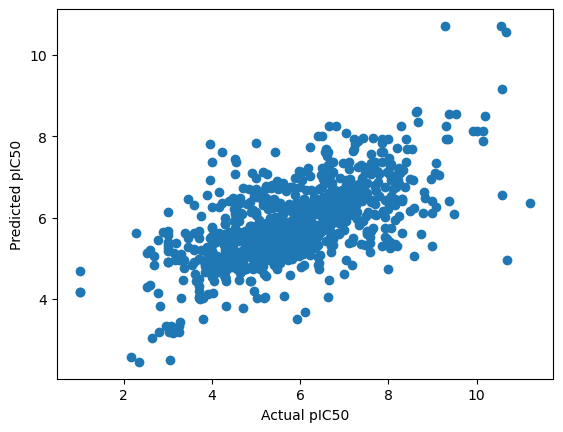

In [93]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')

<Axes: xlabel='pIC50'>

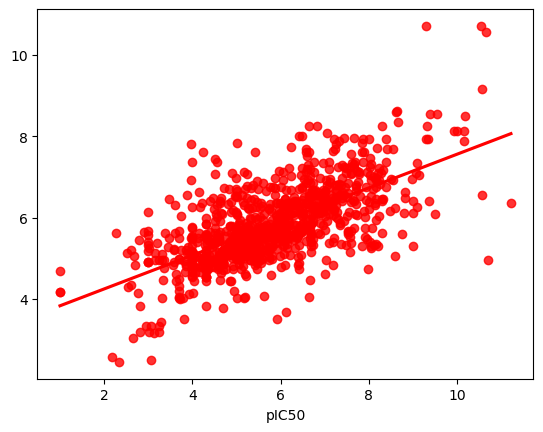

In [91]:
sns.regplot(x=y_test, y=y_test_pred, ci=None, color='red')

#### Difference between Actual and Predicted pIC50 Values

In [94]:
pred_df = pd.DataFrame({'Actual pIC50 Value':y_test, 'Predicted pIC50 Value':y_test_pred, 'Difference':y_test - y_test_pred})
pred_df

,Actual pIC50 Value,Predicted pIC50 Value,Difference
2105,7.519993,5.657557,1.862436
3169,5.677781,5.501067,0.176714
709,7.450997,6.761346,0.689651
2983,8.118615,5.325137,2.793478
184,5.455932,6.385508,-0.929576
...,...,...,...
1881,6.754487,7.368368,-0.613881
4511,5.815309,4.968769,0.846540
962,6.408935,6.292977,0.115958
352,6.632644,6.380659,0.251985
